In [34]:
import pandas  as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme()


In [71]:
df=pd.read_csv("D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\data+marrakach.csv" )
df=df[['date','TES']]
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()

In [73]:
df.loc['2020'] = 0

In [74]:
df.isnull().sum()

TES    2
dtype: int64

In [75]:
df=df.dropna()

In [26]:
#df=df[:120]

## EDA

In [83]:
# df['Date'] = pd.to_datetime(df['Date'])

# # Créer la plage de dates manquantes pour 2020 (12 mois)
# missing_2020 = pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS')

# # Créer un DataFrame avec les dates manquantes et valeur 0
# df_missing = pd.DataFrame({'Date': missing_2020, 'value': 0})

# # Fusionner avec ton DataFrame d'origine
# df_full = pd.concat([df, df_missing], ignore_index=True)
# df_full = df_full.sort_values('Date').reset_index(drop=True)
# df_full=df_full.drop('value',axis=1)
# df=df_full

In [76]:
df.isnull().sum()

TES    0
dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2010-01-01 to 2025-04-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TES     184 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [78]:
df.describe()

,TES
count,184.000000
mean,439553.576087
std,199032.524854
min,0.000000
25%,373181.500000
50%,465730.500000
75%,537267.500000
max,966724.000000


In [79]:
# Graphique interactif
fig = px.line(
    df,
    x=df.index,
    y='TES',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

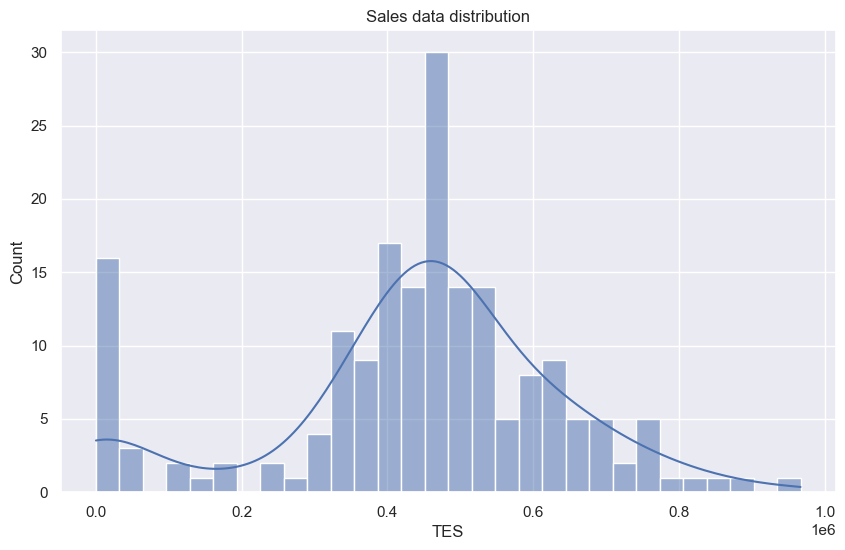

In [80]:
plt.figure(figsize=(10,6))
sns.histplot(df['TES'], kde=True, bins=30)
plt.title("Sales data distribution")
plt.show()

In [82]:
s = pd.to_numeric(df['TES'], errors="coerce").dropna()
nbins = 30

counts, edges = np.histogram(s, bins=nbins)
w = edges[1] - edges[0]
xbar = (edges[:-1] + edges[1:]) / 2

x = np.linspace(s.min(), s.max(), 400)
kde_counts = gaussian_kde(s)(x) * len(s) * w

fig = go.Figure([
    go.Bar(x=xbar, y=counts, width=w, marker_color="#9AC2F7", marker_line=dict(color="white", width=1), name="Count"),
    go.Scatter(x=x, y=kde_counts, mode="lines",marker_color="#144E9A", line=dict(width=2), name="KDE")
])
fig.update_layout(title="Distribution de TES", xaxis_title="TES", yaxis_title="Count", template="simple_white", width=900, height=520)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

##### Time series decomposition

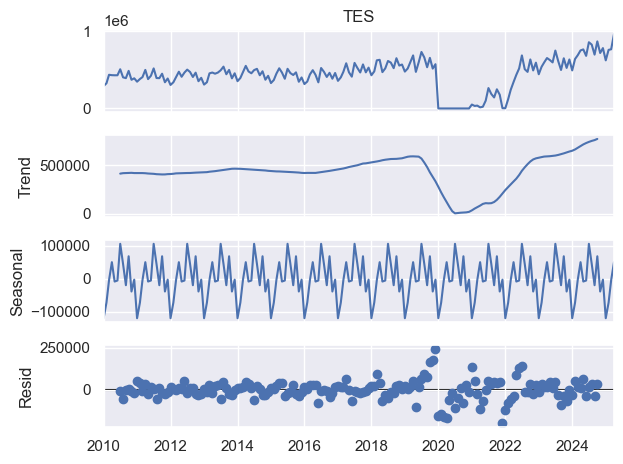

In [83]:
# Seasonal Decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose

    
    result = seasonal_decompose(df['TES'].dropna(), model='additive', period=12)
    result.plot()
    plt.show()
except ImportError:
    print("Statsmodels not installed. Skipping seasonal decomposition.")


#### Augmented Dickey-Fuller test

In [84]:
def test_stationnarite(serie, nom='Serie'):
    result = adfuller(serie.dropna())
    print(f'--- ADF Test fot {nom} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    if result[1] <= 0.05:
        print("✓ Série STATIONNAIRE (p-value ≤ 0.05)")
    else:
        print("✗ Série NON-STATIONNAIRE (p-value > 0.05)")
    


In [85]:
test_stationnarite(df['TES'], 'TES')

--- ADF Test fot TES ---
ADF Statistic: -2.0766
p-value: 0.2540
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [86]:
df['TES_diff1'] = df['TES'].diff()
test_stationnarite(df['TES_diff1'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -2.9738
p-value: 0.0374
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [92]:
ts_d1 = df['TES'].diff().dropna()
ts_d12 = ts_d1.diff(12).dropna()
print("ADF p-value (1st + seasonal diff):", adfuller(ts_d12)[1])

ADF p-value (1st + seasonal diff): 0.0005706579271269705


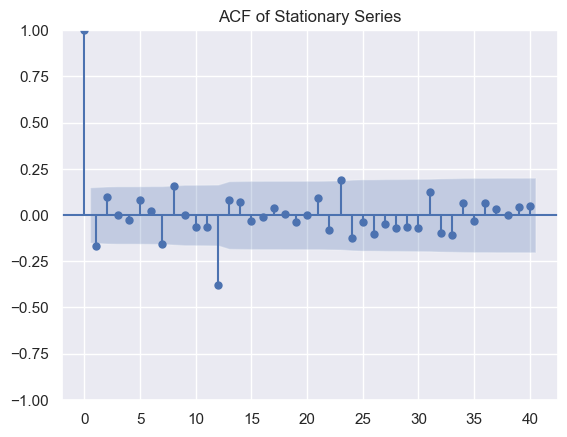

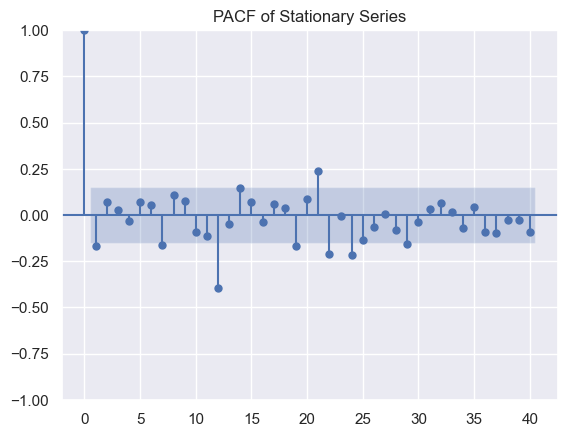

In [93]:
plot_acf(ts_d12,lags=40)
plt.title("ACF of Stationary Series")
plt.show()

plot_pacf(ts_d12,lags=40)
plt.title("PACF of Stationary Series")
plt.show()

## Modeling

In [138]:
df.isnull().sum()

TES          0
TES_diff1    1
dtype: int64

In [322]:
split_point = len(df) - 16
train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

In [315]:
len(train)

162

In [226]:
def grid_search_sarima(train_data, colonne='TES',
                       p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
                       P_range=range(0, 3), D_range=range(0, 3), Q_range=range(0, 3),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

#####  optimal orders

In [323]:
meilleur = grid_search_sarima(train)


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 108
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC: 4310.23
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC: 4282.32
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 3982.86
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3936.23
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 0, 12) - AIC: 3830.16
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 1, 12) - AIC: 3725.77
  Progression: 10/108 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 2, 1, 12) - AIC: 3707.02
  Progression: 20/108 combinaisons testées (20 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(2, 2, 1, 12) - AIC: 3692.18
  Progression: 30/108 combinaisons testées (30 réussies)...
  Progression: 40/108 combinaisons testées (40 réussies)...
  Progression: 50/108 combinaisons testées (50 réussies)...
  Progression: 60/108 combinaisons testées (60 réussies

##### Fiting Model

In [333]:
model = SARIMAX(train["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])
#model_fit=model.fit(disp=False,maxiter=200)   

In [332]:
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  TES   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(2, 2, [1], 12)   Log Likelihood               -1842.088
Date:                              Mon, 13 Oct 2025   AIC                           3692.177
Time:                                      22:20:44   BIC                           3704.028
Sample:                                  01-01-2010   HQIC                          3696.993
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5283      0.164     -3.215      0.001      -0.850      -0.206
ar.S.L24      -0.32

##### Predictions

In [328]:
predictions = results.predict(start=test.index[0], end=test.index[-1])

##### Metrics

In [330]:
rmse = root_mean_squared_error(test['TES'], predictions)
r2 = r2_score(test['TES'], predictions)
mae = mean_absolute_error(test['TES'], predictions)
mape = mean_absolute_percentage_error(test['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:.2%}")
print(f"R²: {r2:.4f}")

=============== Metrics Test ===============
RMSE: 96,017.61
MAE: 79,047.18
MAPE: 10.97%
R²: 20.55%
R²: 0.2055


##### Visualization


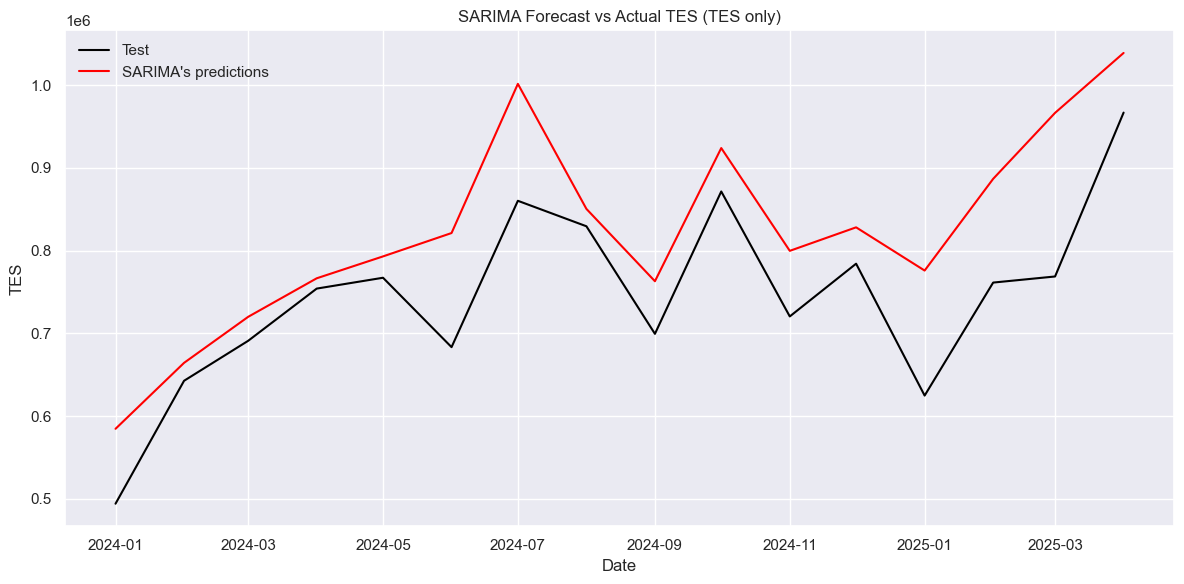

In [326]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index, test['TES'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()